In [32]:
import os
import math
import random
import cv2
import numpy as np
import tensorflow as tf
import re
import sys
import time

#if you have multiple GPU on the machine, choose only one to use on this notebook
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#let the gpu allocates memory space dynamically
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

import matplotlib.pyplot as plt
%matplotlib inline
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [2]:
common_params = {
    'image_size': 224,
    'batch_size': 16,
    'num_classes': 20,
    'max_objects_per_image': 20
}
dataset_params = {
    'path': 'data/pascal_voc_training_data.txt',
    'image_dir': './data/VOCdevkit_train/VOC2007/JPEGImages/',
    'thread_num': 5
}
net_params = {
    'weight_decay': 0.0005,
    'cell_size': 7,
    'boxes_per_cell': 2,
    'object_scale': 1,
    'noobject_scale': 0.5,
    'class_scale': 1,
    'coord_scale': 5, 

}
solver_params = {
    'learning_rate': 0.000001,
    'moment': 0.9,
    'max_iterators': 1200,
    'print_frequency': 100,
    'save_frequency' : 1000,
    'train_dir': 'models/yolo-like'
}

In [3]:
class DatasetRunner:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline ready to be fed into a model.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self, common_params, dataset_params):
        
        self.width = common_params['image_size']
        self.height = common_params['image_size']
        self.batch_size = common_params['batch_size']
        self.num_classes = common_params['num_classes']
        self.data_path = dataset_params['path']
        self.thread_num = dataset_params['thread_num']
        self.image_dir = dataset_params['image_dir']
        
        self.max_objects = common_params['max_objects_per_image']
            
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph, config=config)
        
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(self.data_path, 'r')
        
        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, self.max_objects))
            if len(self.record_list[-1])<self.max_objects*5:
                self.record_list[-1] = self.record_list[-1] +\
                [float(0), float(0), float(0), float(0), float(0)]*\
                (self.max_objects-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1])>self.max_objects*5:
                self.record_list[-1] = self.record_list[-1][:self.max_objects*5]

        self.build_train_data_tensor()
            
    def build_train_data_tensor(self):
        
        def data_generator(image_name, raw_labels, object_num):
            image_file = tf.read_file(self.image_dir+image_name)
            image = tf.image.decode_jpeg(image_file, channels=3)

            h = tf.shape(image)[0]
            w = tf.shape(image)[1]

            width_rate = self.width * 1.0 / tf.cast(w, tf.float32) 
            height_rate = self.height * 1.0 / tf.cast(h, tf.float32) 

            image = tf.image.resize_images(image, size=[self.height,self.width])
            
            raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)
            
            xmin = raw_labels[:, 0]
            ymin = raw_labels[:, 1]
            xmax = raw_labels[:, 2]
            ymax = raw_labels[:, 3]
            class_num = raw_labels[:, 4]
            
            xcenter = (xmin + xmax) * 1.0 / 2.0 * width_rate
            ycenter = (ymin + ymax) * 1.0 / 2.0 * height_rate
            
            box_w = (xmax - xmin) * width_rate
            box_h = (ymax - ymin) * height_rate
            
            labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis = 1)

            return image, labels, tf.cast(object_num, tf.int32)
            

        with self.graph.as_default():
            
            dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                          np.array(self.record_list), 
                                                          np.array(self.object_num_list)))

            dataset = dataset.map(data_generator, num_parallel_calls = self.thread_num)
            dataset = dataset.batch(self.batch_size)
            dataset = dataset.shuffle(self.batch_size) 
            dataset = dataset.repeat()

            self.iterator = tf.data.Iterator.from_structure(dataset.output_types)  
            self.data_init_op = self.iterator.make_initializer(dataset)

            self.sess.run(self.data_init_op)
            self.iterate_op = self.iterator.get_next()
            
    def batch(self):
        images, labels, objects_num = self.sess.run(self.iterate_op)

        if objects_num.shape[0] < self.batch_size:
            images, labels, objects_num = self.sess.run(self.iterate_op)
        
        images = images/255 * 2 - 1
        
        return images, labels, objects_num
        
        
    def __del__(self):
        self.close()

    def close(self):

        self.sess.close()

In [64]:
dataset = DatasetRunner(common_params, dataset_params)
np_images, np_labels, np_objects_num = dataset.batch()
print(np_images.shape,np_labels.shape,np_objects_num.shape)



(16, 224, 224, 3) (16, 20, 5) (16,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


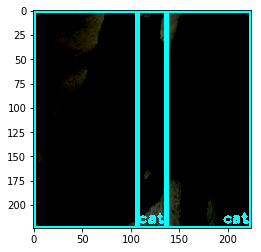

In [74]:
def C2xy(cx,cy):
    x = cx-w/2
    y = cy-h/2
    return x,y
def CWH2xyXY(cx,cy,w,h):
    x = int(cx-w/2)
    y = int(cy-h/2)
    X = int(cx+w/2)
    Y = int(cy+h/2)
    return x,y,X,Y

def plot_bbox(img,coord,class_id):
    for i in range(len(coord)):
        cx,cy,w,h = coord[i]
        
        x,y,X,Y = CWH2xyXY(cx,cy,w,h)
        cv2.rectangle(img, (int(x), int(y)), (int(X), int(Y)), (0, 255, 255), 3)
        if len(class_id) != 0 :
            cv2.putText(img, classes_name[int(class_id[i])], (X-30, Y-5), 1, 1, (0, 255, 255), 2)
    plt.imshow(img)
# test_coord = [[10,10,100,100],[200,200,100,100]]
n =4
plot_bbox(np_images[n],np_labels[n,:np_objects_num[n],:4],np_labels[n,:np_objects_num[n],4])
# plt.imshow(np_images[0])

In [75]:
print(np_labels[3,:5,:])
print(np_labels[n,:np_objects_num[n],:4])

[[148.13866  135.072    151.72266  142.016     15.      ]
 [ 19.712    137.31201   37.034664 136.64      15.      ]
 [192.64     108.864006  62.719997  78.848      3.      ]
 [ 50.176    144.032     74.06933  159.936     14.      ]
 [  0.         0.         0.         0.         0.      ]]
[[165.76001  112.33634  116.48     223.32733 ]
 [ 68.992004 112.33634  136.192    223.32733 ]]


In [22]:
tf.reset_default_graph()
sys.path.append('./')

dataset = DatasetRunner(common_params, dataset_params)
net = YoloTinyNet(common_params, net_params)
model_runner = YoloRunner(dataset, net, common_params, solver_params)



In [23]:
model_runner.run()

step 0, loss = 4356.58 (1.1 examples/sec; 14.748 sec/batch)
step 100, loss = 457.42 (39.2 examples/sec; 0.408 sec/batch)
step 200, loss = 234.94 (38.2 examples/sec; 0.419 sec/batch)
step 300, loss = 270.99 (29.5 examples/sec; 0.543 sec/batch)
step 400, loss = 178.11 (42.0 examples/sec; 0.381 sec/batch)
step 500, loss = 133.19 (30.1 examples/sec; 0.531 sec/batch)
step 600, loss = 106.13 (40.4 examples/sec; 0.396 sec/batch)
step 700, loss = 104.95 (27.7 examples/sec; 0.578 sec/batch)
step 800, loss = 113.47 (31.6 examples/sec; 0.507 sec/batch)
step 900, loss = 94.97 (28.6 examples/sec; 0.560 sec/batch)
step 1000, loss = 100.03 (32.7 examples/sec; 0.490 sec/batch)
step 1100, loss = 116.30 (27.4 examples/sec; 0.584 sec/batch)


In [24]:
def process_predicts(predicts):
    """
    Process YOLO outputs into bou
    """
    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (net_params['cell_size'], net_params['cell_size'], 1, 20))
    C = np.reshape(C, (net_params['cell_size'], net_params['cell_size'], net_params['boxes_per_cell'], 1))
    
    P = C * p_classes
    #P's shape [7, 7, 2, 20]
    #print P[5,1, 0, :]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (net_params['cell_size'], 
                             net_params['cell_size'], 
                             net_params['boxes_per_cell'], 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (common_params['image_size']/float(net_params['cell_size']))
    ycenter = (index[0] + ycenter) * (common_params['image_size']/float(net_params['cell_size']))

    w = w * common_params['image_size']
    h = h * common_params['image_size']

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

In [25]:
tf.reset_default_graph()
common_params['batch_size'] = 1
net = YoloTinyNet(common_params, net_params)
solver = YoloRunner(None, net, common_params, solver_params)

In [26]:
test_img_files = open('data/pascal_voc_testing_data.txt')
test_img_dir = './data/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []
img_size = common_params['image_size']

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])
    
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    
    image_file = tf.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)
    
    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize_images(image, size=[img_size,img_size])
    
    return image_name, image, h, w
test_dataset = test_dataset.map(load_img_data)
test_iterator = test_dataset.make_one_shot_iterator()
next_test_element = test_iterator.get_next()
tdata_sess = tf.Session(config = config)

In [27]:
output_file = open('./data/test_predion.txt', 'w')
solver.prepare_inference(model_version = '1000')

while True:
    try:
        img_name, test_img, img_h, img_w = tdata_sess.run(next_test_element)
        test_img = test_img/255 * 2 - 1
        test_img = np.expand_dims(test_img, axis=0)
        y_pred = solver.make_one_prediction(test_img)
        xmin, ymin, xmax, ymax, class_num, conf = process_predicts(y_pred)

        xmin, ymin, xmax, ymax = xmin*(img_w/img_size), ymin*(img_h/img_size), xmax*(img_w/img_size), ymax*(img_h/img_size)

        #img filename, (xmin, ymin, xmax, ymax, class, confidence)*number_of_predictions
        output_file.write(img_name.decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))
    except tf.errors.OutOfRangeError:
        print("done predicting all test data")
        break
output_file.close()

INFO:tensorflow:Restoring parameters from models/yolo-like/model.ckpt-1000
done predicting all test data


In [29]:
sys.path.insert(0, './evaluate')
from evaluate import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./data/test_predion.txt', './output_file.csv')

End Evalutation


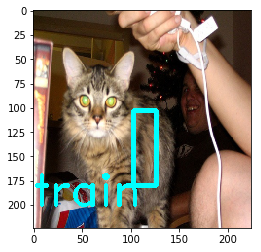

In [33]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]
np_img = cv2.imread('./test.jpg')
resized_img = cv2.resize(np_img, (common_params['image_size'], common_params['image_size']))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, common_params['image_size'], common_params['image_size'], 3))

y_pred = solver.make_one_prediction(np_img)
xmin, ymin, xmax, ymax, class_num, conf = process_predicts(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)